In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from itertools import combinations, product

def prepareData(stats):
    # transform stats to a dictionary composed of df's for each stat
    # the stats are re-calculated to get one stat for each year
    metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P","MP"]
    metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

    metricsPerCentColNames = ["FG","FT"]
    metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

    metricsWeightedColNames = ["PER"]
    metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

    allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    allMetrics = list(allMetricsDict.keys())
    return allPivotedTableDict, allMetrics

# I think there's a bug here
def getActivePlayers(stats, year, buffer, min_games):
    # list of name of the players who were active in this and last year
    thisYear = stats[stats.Year == year].copy()
    thisYear = thisYear[thisYear.G >= min_games]
    players = list(thisYear.Player.unique())
    for i in range(1, buffer+1):
        previousYear = stats[stats.Year == (year-i)].copy()
        players = list(set(players) & set(previousYear.Player.unique()))
    return players

def topPlayers(stats, year, metric, n):
    # n = number of top players 
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player","player_id"]][:n]

def getBenchmark(target, metrics_to_use, pred_interval):    
    target_data, nanIndex = target.concat(metrics_to_use)
    num_k = len(metrics_to_use)
    interv_index = int(target_data.shape[1]/num_k - pred_interval)
    total_index = int(interv_index + 1)
    
    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use
    
    # predictions
    history = utils.get_preint_data(target_data, interv_index, total_index, num_k)
    pred = []
    for i in range(num_k):
        pred.append(history.iloc[:,i*interv_index:(i+1)*interv_index].mean(axis=1).to_list())

    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])
    return true, pred

In [2]:
def plot_pred(pred_traj, true_traj, markers_on, metric, playerName, dir_name_metric):
    dir_name_metric = dir_name + metric + '/'
    plt.figure()
    plt.plot(pred_traj, marker='o', markevery=markers_on, color='blue', label='Prediction')
    plt.plot(true_traj, marker='o', color='red', label='True')
    plt.xticks(range(len(true_traj)), range(1, len(true_traj)+1))
    plt.legend(loc='best')
    plt.xlabel('Years in NBA')
    plt.ylabel(metric)
    plt.title(playerName + ': ' + metric)
    file_name = dir_name_metric + playerName + '.png'
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

def annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name):
    all_pred = pd.DataFrame()
    all_true = pd.DataFrame()
    for playerName in playerNames:
        # print(playerName)
        target = Target(playerName, allPivotedTableDict)
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)

        player_pred = pd.DataFrame()
        player_true = pd.DataFrame()
        
        for metric in metrics_list:
            mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
            pred = mrsc.predict()
            true = mrsc.getTrue()
            pred.columns = [playerName]
            true.columns = [playerName]
            player_pred = pd.concat([player_pred, pred], axis=0)
            player_true = pd.concat([player_true, true], axis=0)

            # plot
            pred_list = mrsc.predict().values.flatten()
            
            for i in range(mrsc.num_k):
                metric = mrsc.metrics[i]
                true_traj = mrsc.target.data[metric].dropna(axis='columns').values.flatten()
                pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                               mrsc.model.beta).flatten()
                
                if mrsc.weighting != None:
                    mean_pre = utils.get_preint_data(combinedDF=mrsc.weights[0].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    var_pre = utils.get_preint_data(combinedDF=mrsc.weights[1].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    mean_pre = mean_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    var_pre = var_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    pred_traj = (pred_traj * np.sqrt(var_pre.T)) + mean_pre.T
                
                pred_traj = np.append(pred_traj, pred_list[i])
                markers_on = [true_traj.shape[0]-mrsc.pred_interval]
                plot_pred(pred_traj, true_traj, markers_on, metric, playerName, dir_name)
    
        all_pred = pd.concat([all_pred, player_pred], axis=1)
        all_true = pd.concat([all_true, player_true], axis=1)

    ###################
    # print(all_pred)
    print(all_pred.shape)
    mask = (all_true !=0 )
    mape = np.abs(all_pred - all_true) / all_true[mask]
    print("*** MAPE ***")
    print(mape.mean(axis=1))
    print("MAPE for all: ", mape.mean().mean())

    rmse = utils.rmse_2d(all_true, all_pred)
    print()
    print("*** RMSE ***")
    print(rmse)
    print("RMSE for all: ", rmse.mean())
    ##############################################################

In [23]:
# for individual player prediction 
def getNormalizedMetric(stats, metric, newColName):
    """
    stats: (df) stats dataframe
    metric: (string) column name of stats df
    newColName: (string) new column name for the processed data
    
    output: (df) for each player, for each year, the per-game metric is computed.
    """
    columnsOfInterest = ["year_count", "Player", "G", metric]
    df = stats.loc[:,columnsOfInterest].groupby(["Player","year_count"]).sum()
    df[newColName] = df[metric]/df["G"]
    return df.iloc[:,-1:]

def getNormalizedMetricDict(stats, metrics):
    """
    stats: (df) stats dataframe
    metrics: (list) column names (strings) of stats df
    
    output: (dict) dict of df's.
    """
    metricsPerGameDict = {}
    for metric in metrics:
        newColName = metric+"_G"
        metricsPerGameDict.update({newColName : getNormalizedMetric(stats, metric, newColName)})
    return metricsPerGameDict


def prepareData_(stats, total_stats, normalized_stats):
    # convert 'total' statistics to 'per game' statistics -> dictionary
    metricsConvertedDict = getConvertedMetricsPerGameDict(stats, total_stats)
    
    # convert 'per game' statistics to dictionary
    metricsNormalizedDict = getNormalizedMetricsDict(stats, normalized_stats)
    
    allMetricsDict = {**metricsConvertedDict, **metricsNormalizedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    return allPivotedTableDict
    
    
    """# transform stats to a dictionary composed of df's for each stat
    # the stats are re-calculated to get one stat for each year
    metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P","MP"]
    metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

    metricsPerCentColNames = ["FG","FT"]
    metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

    metricsWeightedColNames = ["PER"]
    metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

    allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    allMetrics = list(allMetricsDict.keys())
    return allPivotedTableDict, allMetrics"""

In [3]:
""" USER PARAMETERS """
starting_year = 1970 
min_games_donor = 30
min_games_target = 40
pred_year = 2015 # the year that we are living in 
pred_interval = 1 # we are making predictions for pred_year+1 and +2
buffer = 4
total_stats = ["PTS","AST","TOV","TRB","STL","BLK","3P","MP"]
normalized_stats = ["FG%", "3P%", "FT%", "PER"]

"""
import data
"""
print("*** importing data ***")
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
# filter by first season and exclude rookies
players = players[(players.year_start >= starting_year) & (players.year_start < 2018)]

stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats['Player'] = stats['Player'].str.replace('*', '')
stats = stats[stats.Player.isin(players.name)]

""" Filter valid players """
# only look at years in which player played more than 'min_games' games
#stats = stats[stats.G >= min_games_donor]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int) 

print("*** preparing data ***")

########### Donor ##########
# filter stats by the year
stats_donor = stats[stats.Year <= pred_year]
stats_donor = stats_donor[stats_donor.G >= min_games_donor] # donors have to have played certain num. years
allPivotedTableDict_d, allMetrics = prepareData(stats_donor) # prepareData converts to PTS/G
donor = Donor(allPivotedTableDict_d)

########### Target ##########
# filter stats by the year
stats_target = stats[stats.Year <= pred_year+pred_interval]
allPivotedTableDict, allMetrics = prepareData(stats_target)

"""
targets
"""
# targets
playerNames = getActivePlayers(stats, pred_year+pred_interval, buffer=buffer, min_games=min_games_target)
playerNames.sort()
if 'Kevin Garnett' in playerNames: 
    playerNames.remove("Kevin Garnett")
if 'Kobe Bryant' in playerNames:
    playerNames.remove("Kobe Bryant")

print("*** DONE! ***")

*** importing data ***
*** preparing data ***
*** DONE! ***


In [9]:
stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats['Player'] = stats['Player'].str.replace('*', '')
stats = stats[stats.Player.isin(players.name)]
stats.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [17]:
stats.loc[:, ['Player', 'PER', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].head()

,Player,PER,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
1201,Jim Paxson,9.2,138.0,485.0,0.285,NaN,NaN,NaN,138.0,485.0,...,0.720,NaN,NaN,266.0,86.0,NaN,NaN,NaN,163.0,446.0
1312,Jim Paxson,11.6,225.0,639.0,0.352,NaN,NaN,NaN,225.0,639.0,...,0.733,NaN,NaN,350.0,139.0,NaN,NaN,NaN,183.0,659.0
2144,Luke Jackson,15.2,419.0,1013.0,0.414,NaN,NaN,NaN,419.0,1013.0,...,0.713,NaN,NaN,980.0,93.0,NaN,NaN,NaN,251.0,1126.0
2277,Luke Jackson,12.3,246.0,614.0,0.401,NaN,NaN,NaN,246.0,614.0,...,0.738,NaN,NaN,676.0,132.0,NaN,NaN,NaN,216.0,650.0
2409,Luke Jackson,12.3,386.0,882.0,0.438,NaN,NaN,NaN,386.0,882.0,...,0.759,NaN,NaN,724.0,114.0,NaN,NaN,NaN,276.0,970.0


In [21]:
stats[stats.Player == 'A.C. Green'][['PER', 'FG%']]

,PER,FG%
8035,11.8,0.539
8420,15.7,0.538
8807,14.5,0.503
9242,17.8,0.529
9688,14.7,0.478
10166,13.8,0.476
10617,16.7,0.476
11060,16.3,0.537
11529,17.0,0.502
11999,14.2,0.504


In [20]:
allPivotedTableDict['PER_w']

year_count,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,22
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,11.800000,15.700000,14.500000,17.800000,14.7,13.800000,16.700000,16.300,17.000000,14.2,...,12.800000,12.5,11.2,11.2,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Bramlett,-0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. English,10.600000,12.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Guyton,10.300000,11.800000,-9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Price,14.000000,10.700000,11.500000,12.400000,9.7,10.763462,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Wynder,7.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.W. Holt,-1.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Brooks,13.100000,12.900000,16.000000,13.226271,NaN,11.520755,12.401389,14.400,11.800000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Gordon,11.400000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# *** EXPERIMENTAL SECTION ***

In [7]:
predMetrics = ["PTS_G","AST_G","TOV_G","FG%","FT%","3P_G","TRB_G","STL_G","BLK_G"]
offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G"]
defMetrics = ["TRB_G","STL_G","BLK_G"]

# *** MRSC (uniform weights + sliding) ***

mRSC (10 metrics at once + sliding)


KeyboardInterrupt: 

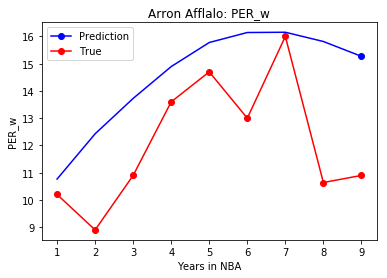

In [59]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.98
verbose = False
metrics_list = [predMetrics]
dir_name = 'plots/plots_mrsc_sliding/none/'

"""
experiment
"""
print("mRSC (10 metrics at once + sliding)")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

In [ ]:
mRSC (10 metrics at once + sliding)
(10, 166)
*** MAPE ***
PTS_G    0.314745
AST_G    0.773034
TOV_G    0.492397
TRB_G    0.343563
STL_G    0.498881
BLK_G    1.044325
3P_G     1.382008
FG%      0.164867
FT%      0.195588
PER_w    0.177700
dtype: float64
MAPE for all:  0.5235407480705643

*** RMSE ***
PTS_G    3.389192
AST_G    1.346442
TOV_G    0.582728
TRB_G    1.557268
STL_G    0.369349
BLK_G    0.299545
3P_G     0.721950
FG%      0.094014
FT%      0.183877
PER_w    3.012337
dtype: float64
RMSE for all:  1.1556702557123049

# *** MRSC (variance weights + sliding) ***

mRSC (10 metrics at once + sliding)


KeyboardInterrupt: 

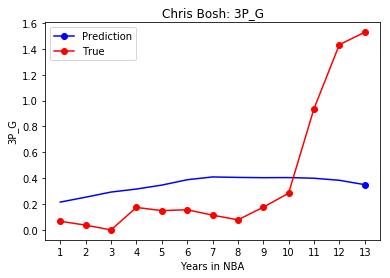

In [102]:
"""
experiment setup
"""
# overall setup
donorSetup= ["variance_batch","sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.97
verbose = False
metrics_list = [predMetrics]
dir_name = 'plots/plots_mrsc_sliding/variance/'

"""
experiment
"""
print("mRSC (10 metrics at once + sliding)")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

# *** MRSC (with MP_G + sliding) ***

In [111]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.99
verbose = False
metrics_list = [[metric, 'MP_G'] for metric in predMetrics]
dir_name = 'plots/mrsc/sliding/no_normalization/with_MP_G/'

"""
experiment
"""
print("mRSC (with MP_G + sliding)")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

mRSC (with MP_G + sliding)
(20, 186)
*** MAPE ***
PTS_G    0.347745
MP_G     0.227111
AST_G    0.513795
MP_G     0.228307
TOV_G    0.486224
MP_G     0.223998
PER_w    0.165515
MP_G     0.215543
FG%      0.217454
MP_G     0.217059
FT%      0.210404
MP_G     0.217077
3P_G     2.161737
MP_G     0.223685
TRB_G    0.294457
MP_G     0.227079
STL_G    0.494292
MP_G     0.220242
BLK_G    1.500743
MP_G     0.224884
dtype: float64
MAPE for all:  0.4166239084947398

*** RMSE ***
PTS_G    4.099379
MP_G     6.623509
AST_G    1.254278
MP_G     6.610443
TOV_G    0.727324
MP_G     6.573855
PER_w    2.988817
MP_G     6.359617
FG%      0.129613
MP_G     6.445818
FT%      0.205697
MP_G     6.445547
3P_G     0.897202
MP_G     6.569348
TRB_G    1.513353
MP_G     6.597333
STL_G    0.409193
MP_G     6.486783
BLK_G    0.428781
MP_G     6.589906
dtype: float64
RMSE for all:  3.8977897852211436


# *** MRSC ('MP_G + PER_w', sliding, no-normalization) ***

In [ ]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.99
verbose = False
metrics_list = [[metric, 'MP_G', 'PER_w'] for metric in predMetrics]
dir_name = 'plots/mrsc/sliding/no_normalization/with_MP_G/'

"""
experiment
"""
print("mRSC (with MP_G + sliding)")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

# *** MRSC (offense/defense + sliding + no normalization) ***

In [6]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.99
verbose = False
metrics_list = [offMetrics]
dir_name = 'plots/mrsc/sliding/no_normalization/offense_defense/'

"""
experiment
"""
print("Begin...")
print() 
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

Begin...

(7, 186)
*** MAPE ***
PTS_G    0.457109
AST_G    0.590477
TOV_G    0.482819
PER_w    0.218816
FG%      0.145016
FT%      0.202350
3P_G     1.763926
dtype: float64
MAPE for all:  0.5209563535505045

*** RMSE ***
PTS_G    5.429079
AST_G    1.227277
TOV_G    0.692079
PER_w    3.998826
FG%      0.083950
FT%      0.189830
3P_G     0.875733
dtype: float64
RMSE for all:  1.7852533696644743


In [9]:
"""
experiment setup
"""
dir_name = 'plots/mrsc/sliding/no_normalization/offense_defense/'
metrics_list = [defMetrics]

"""
experiment
"""
print("Begin...")
print() 
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

Begin...

(3, 186)
*** MAPE ***
TRB_G    0.310025
STL_G    0.346743
BLK_G    0.570833
dtype: float64
MAPE for all:  0.40920002277577655

*** RMSE ***
TRB_G    1.552094
STL_G    0.292491
BLK_G    0.212465
dtype: float64
RMSE for all:  0.685683187256156


# *** RSC (fixed window) ***

In [13]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"fixed", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.98
verbose = False
metrics_list = [[metric] for metric in predMetrics]
dir_name = 'plots/rsc/fixed/pred_2_year/'

"""
experiment
"""
print("Running...")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

Running...


ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

# *** RSC (sliding window) ***

In [127]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"
threshold = 0.98
verbose = False
metrics_list = [[metric] for metric in predMetrics]
dir_name = 'plots/rsc/sliding/'

"""
experiment
"""
print("RSC (sliding window)")
annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                   threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name) 

RSC (sliding window)
(10, 10)
*** MAPE ***
PTS_G    0.572397
AST_G    0.653616
TOV_G    0.587547
PER_w    0.120509
FG%      0.093023
FT%      0.079664
3P_G     1.225617
TRB_G    0.424570
STL_G    0.362635
BLK_G    0.663547
dtype: float64
MAPE for all:  0.4587379918731426

*** RMSE ***
PTS_G    3.533614
AST_G    0.719372
TOV_G    0.521395
PER_w    1.720438
FG%      0.060720
FT%      0.064781
3P_G     0.515827
TRB_G    2.109641
STL_G    0.254181
BLK_G    0.309913
dtype: float64
RMSE for all:  0.98098807009476


In [34]:
# debug
playerName = playerNames[0]
playerName = 'James Harden'
metrics_list = [[metric] for metric in predMetrics]
metric = metrics_list[0]

# print(playerName)
target = Target(playerName, allPivotedTableDict)
mrsc = mRSC(donor, target, pred_interval, probObservation=1)

mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)

# plot
pred_list = mrsc.predict()
pred_list

,0,1
PTS_G,27.8184,25.1594


In [35]:
stats[stats.Player == playerName]['PTS']/stats[stats.Player == playerName]['G']

15787     9.907895
16412    12.170732
16975    16.838710
17511    25.935897
18116    25.356164
18710    27.370370
19303    28.975610
19874    29.086420
dtype: float64

In [113]:
i = 0
metric = mrsc.metrics[i]
true_traj = mrsc.target.data[metric].dropna(axis='columns').values.flatten()
pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                   mrsc.model.beta).flatten()

mean_pre = utils.get_preint_data(combinedDF=mrsc.weights[0].to_frame().T,
                                intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                nbrMetrics=mrsc.num_k, reindex=True)

var_pre = utils.get_preint_data(combinedDF=mrsc.weights[1].to_frame().T,
                                intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                nbrMetrics=mrsc.num_k, reindex=True)

['PTS_G', 'MP_G']

In [ ]:

def annual_predictions(playerNames, allPivotedTableDict, donor, pred_interval, metrics_list,
                      threshold, donorSetup, denoiseSetup, regression_method, verbose, dir_name):
    all_pred = pd.DataFrame()
    all_true = pd.DataFrame()
    for playerName in playerNames:
        # print(playerName)
        target = Target(playerName, allPivotedTableDict)
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)

        player_pred = pd.DataFrame()
        player_true = pd.DataFrame()
        
        for metric in metrics_list:
            mrsc.fit_threshold(metric, threshold, donorSetup, denoiseSetup,regression_method, verbose)
            pred = mrsc.predict()
            true = mrsc.getTrue()
            pred.columns = [playerName]
            true.columns = [playerName]
            player_pred = pd.concat([player_pred, pred], axis=0)
            player_true = pd.concat([player_true, true], axis=0)

            # plot
            pred_list = mrsc.predict().values.flatten()
            
            for i in range(mrsc.num_k):
                metric = mrsc.metrics[i]
                true_traj = mrsc.target.data[metric].dropna(axis='columns').values.flatten()
                pred_traj = np.dot(mrsc.model.donor_pre.iloc[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].T, 
                               mrsc.model.beta).flatten()
                
                if mrsc.weighting != None:
                    mean_pre = utils.get_preint_data(combinedDF=mrsc.weights[0].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    var_pre = utils.get_preint_data(combinedDF=mrsc.weights[1].to_frame().T,
                                                    intervIndex=mrsc.interv_index, totalIndex=mrsc.total_index,
                                                    nbrMetrics=mrsc.num_k, reindex=True).values
                    mean_pre = mean_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    var_pre = var_pre[:, i*mrsc.model.interv_index:(i+1)*mrsc.model.interv_index].flatten()
                    pred_traj = (pred_traj * np.sqrt(var_pre.T)) + mean_pre.T
                
                pred_traj = np.append(pred_traj, pred_list[i])
                markers_on = [true_traj.shape[0]-mrsc.pred_interval]
                plot_pred(pred_traj, true_traj, markers_on, metric, playerName, dir_name)
    
        all_pred = pd.concat([all_pred, player_pred], axis=1)
        all_true = pd.concat([all_true, player_true], axis=1)

    ###################
    # print(all_pred)
    print(all_pred.shape)
    mask = (all_true !=0 )
    mape = np.abs(all_pred - all_true) / all_true[mask]
    print("*** MAPE ***")
    print(mape.mean(axis=1))
    print("MAPE for all: ", mape.mean().mean())

    rmse = utils.rmse_2d(all_true, all_pred)
    print()
    print("*** RMSE ***")
    print(rmse)
    print("RMSE for all: ", rmse.mean())
    ##############################################################